In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
import xgboost as xgb

In [3]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Imports successful")

✓ Imports successful


In [4]:
# Using breast cancer dataset (binary classification)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(f"\nDataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution:\n{y.value_counts()}")


Dataset shape: (569, 30)
Classes: [0 1]
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Initialize the model
model = xgb.XGBClassifier(
    n_estimators=100,        # number of trees
    max_depth=6,             # maximum tree depth
    learning_rate=0.1,       # eta - step size shrinkage
    subsample=0.8,           # subsample ratio of training data
    colsample_bytree=0.8,    # subsample ratio of columns
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)


In [9]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [10]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n{'='*50}")
print(f"MODEL PERFORMANCE")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



MODEL PERFORMANCE
Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.93      0.95        42
      benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Cross-validation scores: [0.95604396 1.         0.94505495 0.97802198 0.97802198]
Mean CV accuracy: 0.9714 (+/- 0.0192)


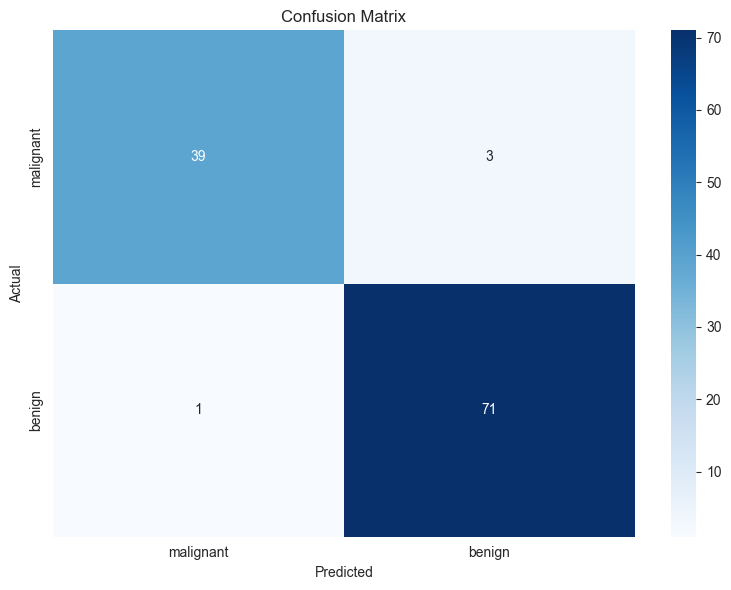

C:\Users\Joseph\AppData\Local\Temp\ipykernel_11208\3739019014.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')


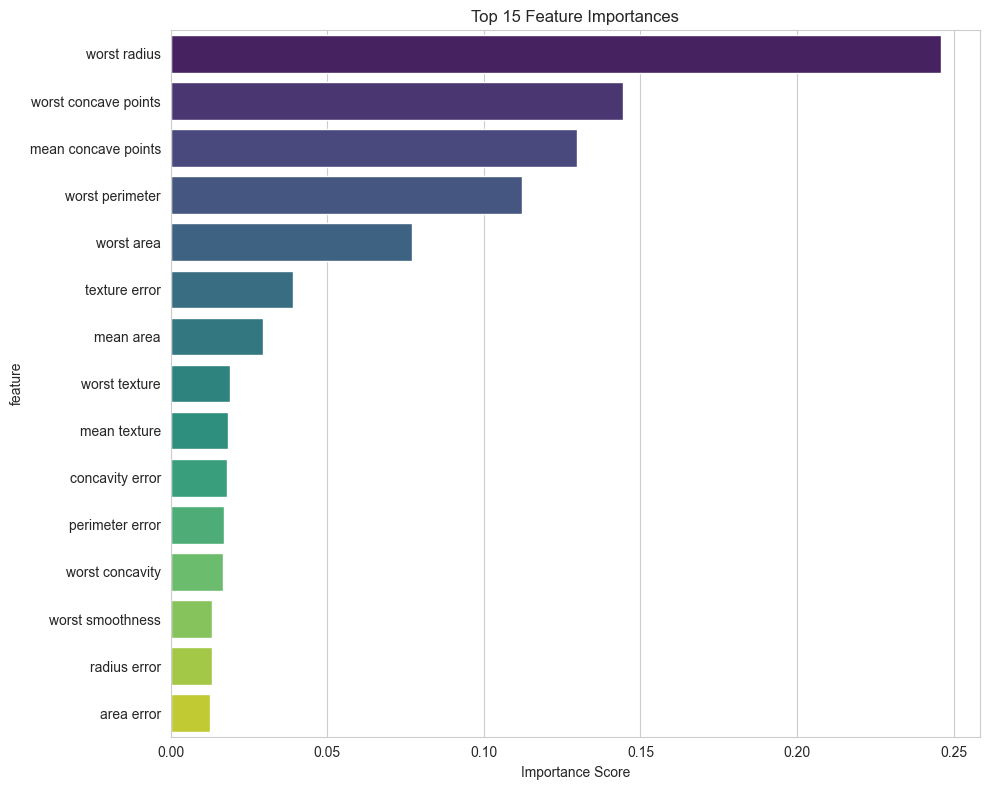

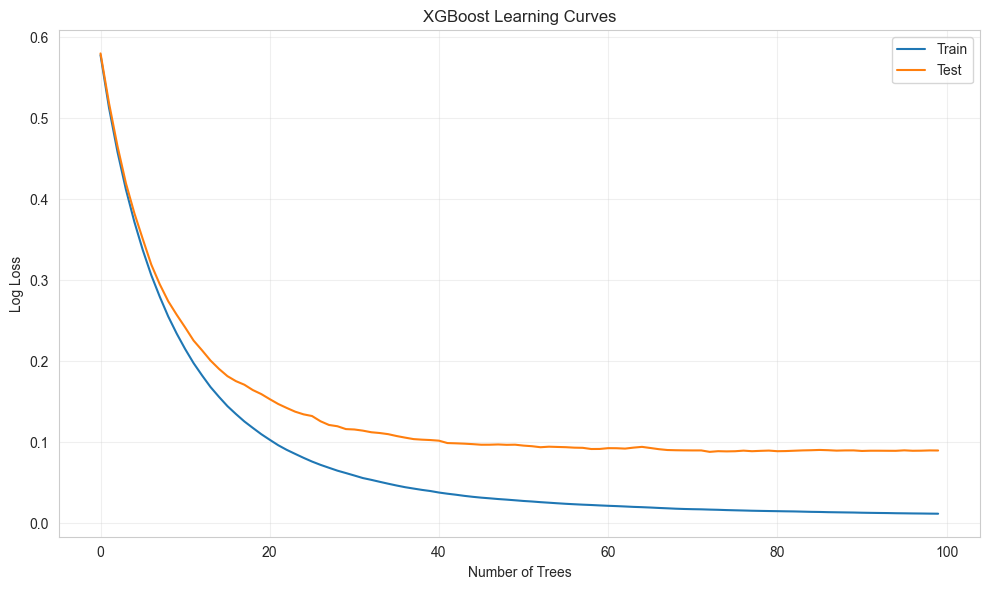

In [12]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Learning Curves
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
